# Colony Picking Optomizer
### Author: Frank Escalante
### Last Updated: 05/14/2024

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageDraw, ImageFilter
import matplotlib.image as img
import cv2
import random

In [247]:
def plate(uniq_DNA, Total_CFUs_pickable,plt_ID):
    DNAs = []
    plte = []
    for DNA in range(0,uniq_DNA):
        DNAs.append(DNA)
    counter = 0
    for CFUs in range(0,Total_CFUs_pickable):
        tracker = round(Total_CFUs_pickable/uniq_DNA) + Total_CFUs_pickable % uniq_DNA
        if counter <= max(DNAs):
            plte.append(DNAs[counter])
            counter += 1
        elif counter > max(DNAs):
            counter = 0
            plte.append(DNAs[counter])
            counter += 1
    return (plte,plt_ID)

def plt_imgr(images):
    pickable_CFUs_per_plate = []
    for imagee in images:
        cimg = cv2.imread(imagee) #upload image; in color

        img = cv2.imread(imagee,0) #upload image; second arg 0 corresponds to grayscale image upload

        #img = cv2.resize(img, (0, 0), fx = 0.5, fy = 0.5) #resize to half the size
        img = cv2.medianBlur(img,5) # Blur the image; sometimes increases accuracy of algorithm
        edges = cv2.Canny(img, threshold1=10, threshold2=30) #convert image to edges

        # Perform the hough transform to detect circles
        # First arg = gray scaled image
        # Second arg = Hough method
        # Third arg = ??? leave alone
        # Fourth arg = The min distance between centers of circles found
        # Fifth, Sixth Args = Determine the thresholds for circle detection; the higher the values the more accurate;
        #      Fifth arg has a ceiling at 300; for low resolution or unclear images try lowering the values
        # Seventh, Eigth args = Determine max and min sizes for circles allowed to be detected
        circles = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,1,10, param1=160,param2=10,minRadius=2,maxRadius=7)
        #print(type(circles))

        # take the vector output of circles and approximate the center location and radius via rounding to the 2nd decimal place
        detected_circles = np.uint16(np.around(circles,2))

        # Now draw the detected circles over the image
        for circle_parameters in detected_circles[0,:]:
            x_coord = circle_parameters[0]
            y_coord = circle_parameters[1]
            radius = circle_parameters[2]
        # draw the outer circle
            cv2.circle(cimg,(x_coord,y_coord),radius,(255,0,0),1) # the last parameter dictates the thickness of the circles
        # draw the center of the circle; give the radius of the inner circle (center) a very small radius ~1
            cv2.circle(cimg,(x_coord,y_coord),1,(0,0,255),1) # The tuple represents the color of the circles

        pickable_CFUs = detected_circles.shape[1] - 50 # The method seems to always overestimate, so a random 50 is subtracted
        ID = str(imagee[:-4])+ '_' + str(pickable_CFUs) + '.jpg'

        cv2.imwrite(ID,cimg)
        pickable_CFUs_per_plate.append((pickable_CFUs, ID))
    return pickable_CFUs_per_plate

In [248]:
unique_DNAs_per_plate = 25
CFUs_all_plates = plt_imgr(['Yeast Test Plate.png'])
Simulation_plates = []
for plte in CFUs_all_plates:
    plate_simulation = plate(unique_DNAs_per_plate,plte[0],plte[1])
    Simulation_plates.append(plate_simulation)

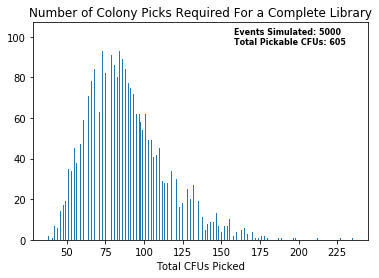

In [253]:
trial_results = []
ttl_trials = 5000
uni_DNAs = 25
for plate_info in Simulation_plates:
    plate = plate_info[0]
    ID = plate_info[1]
    ttl_CFUs_availible = len(plate)
    for trial in range(0,ttl_trials):
        CFUs_Picked = []
        ttl_picks = 0
        plate_copy = plate.copy()
        while list(set(plate)) != list(set(CFUs_Picked)):
            CFU = random.choice(plate_copy)
            index = plate_copy.index(CFU)
            picked_CFU = plate_copy.pop(index)
            CFUs_Picked.append(picked_CFU)
            ttl_picks +=1
        trial_results.append(ttl_picks)

#trial_results
    n, bins, patches = plt.hist(trial_results,bins = int((unique_DNAs_per_plate-1)* ttl_CFUs_availible/unique_DNAs_per_plate)+1)
    plt.title("Number of Colony Picks Required For a Complete Library")
    plt.xlabel("Total CFUs Picked")
    plt.annotate("Events Simulated: " + str(ttl_trials) + '\nTotal Pickable CFUs: ' + str(ttl_CFUs_availible), xy =(0.6,0.9), xycoords = 'axes fraction', weight='bold',size = 8)
    plt.savefig(ID[:-4] + ' Simulation Results.jpeg')
    plt.show()
